In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

In [2]:
data_dir = './dataset-resized/'

In [3]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                                           [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader


In [4]:
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)
print(trainloader.dataset.imgs)

['can', 'paper', 'plastic', 'trash']


[('./dataset-resized/can\\001820000063.jpg', 0), ('./dataset-resized/can\\002241-1-1.jpg', 0), ('./dataset-resized/can\\007089701371.jpg', 0), ('./dataset-resized/can\\007336018754.jpg', 0), ('./dataset-resized/can\\031-36-argonaut.jpg', 0), ('./dataset-resized/can\\04_Beer20Can20preview20image.jpg', 0), ('./dataset-resized/can\\083942-peroni-beer--can-cl33x24.jpg', 0), ('./dataset-resized/can\\1-2-324x324.jpg', 0), ('./dataset-resized/can\\1-8-324x324.jpg', 0), ('./dataset-resized/can\\100_Budlight_beer_can_12_FL_1000_0001.jpg', 0), ('./dataset-resized/can\\10311101-beer-cans-isolated-on-white-background-design-of-these-cans-is-my-own-and-all-text-labels-are-fully-.jpg', 0), ('./dataset-resized/can\\108320.jpg', 0), ('./dataset-resized/can\\12567928_L1.jpg', 0), ('./dataset-resized/can\\12PACK_CAN_WEB.jpg', 0), ('./dataset-resized/can\\1474876997588.jpg', 0), ('./dataset-resized/can\\152607766.jpg', 0), ('./dataset-resized/can\\1552434440-four_corners_topless.jpg', 0), ('./dataset-res

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 1.921.. Test loss: 1.030.. Test accuracy: 0.784
Epoch 1/10.. Train loss: 0.862.. Test loss: 0.502.. Test accuracy: 0.822
Epoch 1/10.. Train loss: 0.490.. Test loss: 0.402.. Test accuracy: 0.849
Epoch 1/10.. Train loss: 0.372.. Test loss: 0.464.. Test accuracy: 0.809
Epoch 1/10.. Train loss: 0.407.. Test loss: 0.427.. Test accuracy: 0.835
Epoch 1/10.. Train loss: 0.410.. Test loss: 0.403.. Test accuracy: 0.854
Epoch 2/10.. Train loss: 0.493.. Test loss: 0.300.. Test accuracy: 0.899
Epoch 2/10.. Train loss: 0.341.. Test loss: 0.291.. Test accuracy: 0.900
Epoch 2/10.. Train loss: 0.389.. Test loss: 0.306.. Test accuracy: 0.890
Epoch 2/10.. Train loss: 0.275.. Test loss: 0.286.. Test accuracy: 0.885
Epoch 2/10.. Train loss: 0.364.. Test loss: 0.322.. Test accuracy: 0.876
Epoch 2/10.. Train loss: 0.396.. Test loss: 0.453.. Test accuracy: 0.833
Epoch 3/10.. Train loss: 0.344.. Test loss: 0.391.. Test accuracy: 0.857
Epoch 3/10.. Train loss: 0.341.. Test loss: 0.340..

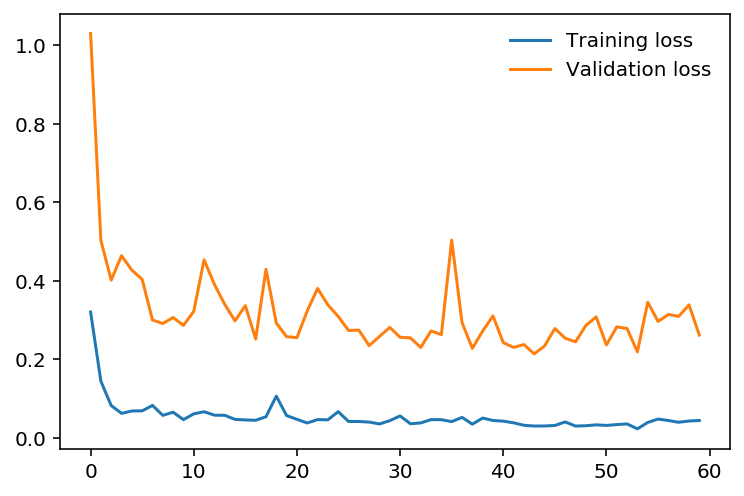

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = 'model.pth'
torch.save(model, PATH)

C:\Users\multicampus\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\multicampus\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\multicampus\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\multicampus\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for cor